<img src = "https://img.theweek.in/content/dam/week/news/sports/images/2021/12/13/hamilton-verstappen-formula-one-abu-dhabi-f1-twitter.jpg" height = 300 width = 500></img>
# **Building the Model & Predicting for F1 Twitter Sentiment Analysis**
In this project, I am going to be constructing a model to predict the sentiment of F1 Twitter following the 2021 Abu Dhabi Grand Prix 

The model will be trained on Sentiment140 dataset, and used to predict the sentiment of F1 twitter
<br>

## Importing Libraries

In [44]:
import re
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import pickle

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define regular expressions to remove URLs, mentions, hashtags, and other unwanted text
url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#\w+')
html_tag_re = re.compile(r'<.*?>')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing Sentiment140 Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/F1Twitter/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Cleaning Dataset

In [ ]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


## Preprocessing Dataset

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

## Training the Model
### Splitting into Train and Test


In [ ]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 35

In [ ]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [ ]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


### Tokenizing

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


### Padding to ensure there is no difference in size of input

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 35)
Testing X Shape: (320000, 35)


In [ ]:
labels = train_data.sentiment.unique().tolist()
labels

['Negative', 'Positive']

### Label Encoding

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


### Word Embedding
Using a pretrained word embedder

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-04-06 10:56:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-06 10:56:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-06 10:56:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = 'best_model.hdf5'

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

## Creating Model

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [ ]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])


Epoch 1/10
1250/1250 [==============================] - 206s 152ms/step - loss: 0.5202 - accuracy: 0.7383 - val_loss: 0.4821 - val_accuracy: 0.7659 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 186s 149ms/step - loss: 0.4878 - accuracy: 0.7619 - val_loss: 0.4708 - val_accuracy: 0.7731 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 188s 150ms/step - loss: 0.4776 - accuracy: 0.7687 - val_loss: 0.4676 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 183s 146ms/step - loss: 0.4714 - accuracy: 0.7728 - val_loss: 0.4655 - val_accuracy: 0.7764 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 188s 150ms/step - loss: 0.4667 - accuracy: 0.7758 - val_loss: 0.4612 - val_accuracy: 0.7790 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 188s 150ms/step - loss: 0.4635 - accuracy: 0.7778 - val_loss: 0.4600 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 7/10
1250/1250 [============

### Saving the model

In [ ]:

pickle.dump(model, open('LSTMModel.pkl', 'wb'))

### Calculating Model Accuracy & Loss

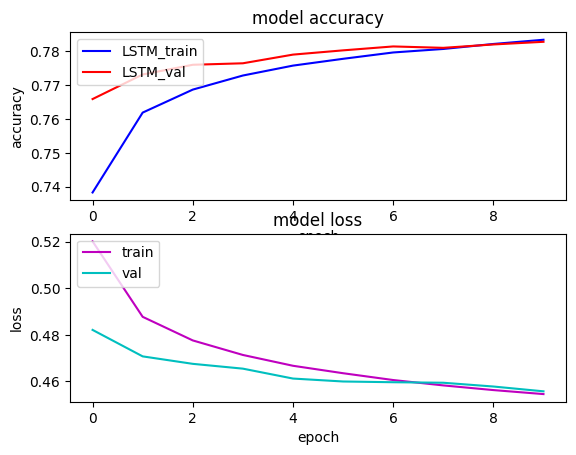

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [ ]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 4s 82ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.78      0.78    160542
    Positive       0.78      0.79      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



# **Using Model to Predict on F1 Twitter Data**

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/ML/F1Twitter/LSTMModel.pkl', 'rb'))

## Importing F1 Twitter Dataset

In [ ]:
tweets_df = pd.read_csv('/content/drive/MyDrive/ML/F1Twitter/replies.csv')
tweets_df.head()

,id,date,text,user
0,1474892038067916802,2021-12-25 23:57:18+00:00,@TTejpal @ecemscrp @fia @Ben_Sulayem @redbull ...,jmart1226
1,1474891487674617864,2021-12-25 23:55:07+00:00,@yadadoo20 @SchlowL @F1 @Max33Verstappen @redb...,vector2alpha
2,1474889745293578243,2021-12-25 23:48:12+00:00,@MeterePopularis @dazib007 @mrsnek18 @FactosMe...,fil3638
3,1474889292103176194,2021-12-25 23:46:24+00:00,@MeterePopularis @dazib007 @mrsnek18 @FactosMe...,fil3638
4,1474887568718286852,2021-12-25 23:39:33+00:00,@stuartmblatch @FormuIaMax @redbullracing @Hon...,danny_chips_


## Preprocessing and Preparing Data for prediction

In [26]:
def preprocess_tweet(tweet):
    # Remove URLs, mentions, hashtags, and HTML tags
    tweet = url_re.sub('', tweet)
    tweet = mention_re.sub('', tweet)
    tweet = hashtag_re.sub('', tweet)
    tweet = html_tag_re.sub('', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Tokenize tweet into words
    words = word_tokenize(tweet)
    
    # Remove stopwords and non-alphabetic characters
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalpha() and word not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into a single string
    tweet = ' '.join(words)
    
    return tweet

# Define function to preprocess a dataset of tweets
def preprocess_dataset(dataset):
    # Apply preprocessing to each tweet in the dataset
    preprocessed_tweets = [preprocess_tweet(tweet) for tweet in dataset]
    
    return preprocessed_tweets

In [27]:
preprocessed_tweets = preprocess_dataset(tweets_df['text'].values)

In [36]:
tweets_df.text = preprocessed_tweets

In [32]:
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 35

## Tokenizing

In [37]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_df.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 12548


In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
tweets_text = pad_sequences(tokenizer.texts_to_sequences(tweets_df.text),
                        maxlen = MAX_SEQUENCE_LENGTH)

print(tweets_text.shape)

(25000, 35)


## Predicting Sentiment Over F1 Twitter Dataset

In [39]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(tweets_text)
y_pred_1d = [decode_sentiment(score) for score in scores]

782/782 [==============================] - 21s 27ms/step


In [41]:
predictions = pd.DataFrame({
    'tweet': tweets_df['text'],  # Select column 'B' from existing dataframe
    'sentiment': y_pred_1d  # New array of elements
})
predictions

,tweet,sentiment
0,bro stop trying hard take l instead,Positive
1,forget strategy year mercedes got wrong many t...,Positive
2,seem obsessed bringing race racism cool,Negative
3,enjoy life alternate universe,Positive
4,scenario rain change position lh rain amp gloc...,Negative
...,...,...
24995,dude lot friend hate blm hate act violence bur...,Negative
24996,kid proud gift ok let ruin career micky mouse,Positive
24997,ask verstappen lucked last race yes big time m...,Negative
24998,kinda like russian got olympic medal know,Positive


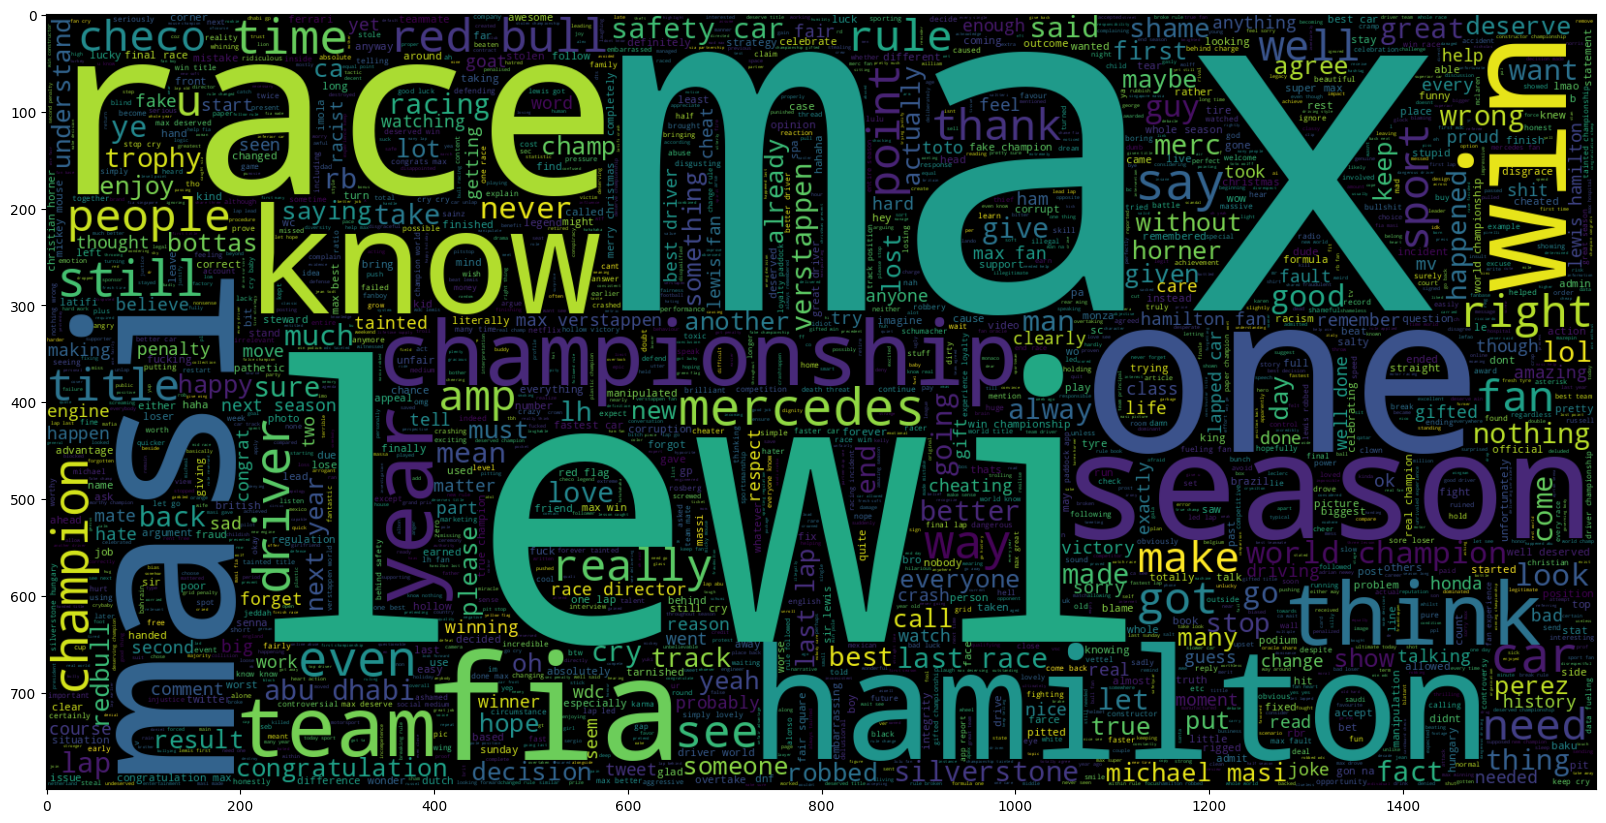

In [43]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(predictions.tweet))
plt.imshow(wc , interpolation = 'bilinear')

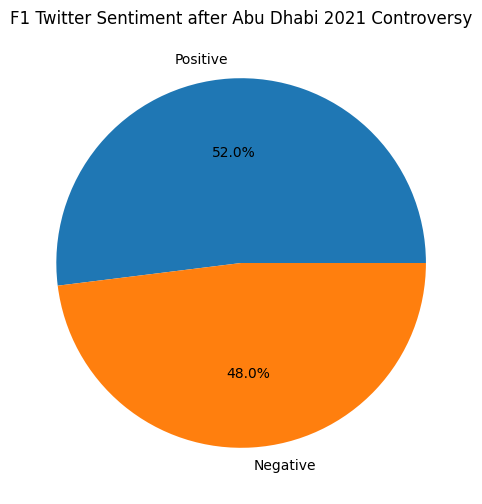

In [47]:
sentiment_counts = predictions['sentiment'].value_counts()

# plot a pie chart of the sentiment distribution
plt.figure(figsize=(8,6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('F1 Twitter Sentiment after Abu Dhabi 2021 Controversy')
plt.show()